In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from numpy.random import RandomState
from itertools import product

# dane
from sklearn.datasets import fetch_mldata
# splity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# modele
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
# metryki
from sklearn.metrics import accuracy_score

mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

# zawsze przed uczeniem/splitami proszę zrobić shuffle na danych!

## Ćwiczenie 1 [2 pkt]

Napisać trzy generatory zestawów hiperparametrów:
* generator grid search [robimy wspólnie za 0 pkt],
* generator k elementów random grid search,
* generator k elementów random search.

Hiperparametry podajemy jako słownik {nazwa_hiperparametru: lista_wartości/rozkład}.

Generator ma yieldować słowniki {nazwa_hiperparametru: wartość_hiperparametru}

Rozkłady prawdopodobieństwa możecie Państwo podawać w dowolny sposób - np. jako pythonową funkcję, jako string z nazwą (a możliwe rozkłady zakodować na sztywno w funkcji zwracającej generatory) itp. Proponuję zastosować konwencję opisaną w następnej komórce [czy ktoś z Państwa ma inny pomysł, jak podawać rozkłady?].

Losowe generatory mają przyjmować random_state i działać deterministycznie przy ustalonym random_state (należy ustawić w środku seed generatora liczb losowych na random_state).


In [2]:
# Tworzymy fabryki samplerów, każda fabryka parametryzuje pewną rodzinę rozkładów prawdopodobieństwa
# sampler pamięta jeden konkretny rozkład prawdopodobieństwa
# jedynym argumentem samplera jest obiekt numpy.random.RandomState, który oznaczamy rng
# sampler zwraca jedną wartość ze swojego rozkładu
# ponieważ rng pamięta swój stan, to możemy np. raz stworzyć go na początku i podawać w pętli

# rodzina rozkładów jednostajnych na podanych listach elementów
# sampler losuje z rozkładu jednostajnego na liście l
def uniform_from_list(l):
    def sampler(rng):
        return l[rng.randint(0,len(l))]
    return sampler

# rodzina rozkładów jednostajnych na przedziałach liczb całkowitych
# sampler losuje z rozkładu jednostajnego na podzbiorze liczb całkowitych od low (włącznie) do high (wyłącznie)
def uniform_int_on_interval(low, high):
    def sampler(rng):
        return rng.randint(low,high)
    return sampler

# rodzina rozkładów jednostajnych na przedziałach
# sampler losuje z rozkładu jednostajnego na przedziale [low, high]
def uniform_on_interval(low, high):
    def sampler(rng):
        return rng.uniform(low, high)
    return sampler

# rodzina rozkładów jednostajnych na przedziałach w wykładniku potęgi liczby 10
# sampler losuje liczbę alpha z rozkładu jednostajnego na przedziale [low, high], a następnie zwraca 10^alpha
def log_uniform_on_interval(low, high):
    def sampler(rng):
        return 10.**rng.uniform(low, high)
    return sampler

# rodzina rozkładów gaussa
# sampler losuje liczbę z rozkładu N(mean, std^2)
def normal(mean, std):
    def sampler(rng):
        return rng.normal(loc=mean, scale=std)
    return sampler

# rodzina rozkładów gaussa w wykładniku potęgi liczby 10
# sampler losuje liczbę alpha z rozkładu N(mean, std^2), a następnie zwraca 10^alpha
def log_normal(mean, std):
    def sampler(rng):
        return 10**rng.normal(loc=mean, scale=std)
    return sampler

In [3]:
print("Tworzymy obiekt klasy RandomState")
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print("Losujemy...")
for _ in range(4):
    print(s1(rng), s2(rng), s3(rng))

print("")
print("Resetujemy RandomState")
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print("Losujemy...")
for _ in range(4):
    print(s1(rng), s2(rng), s3(rng))

print("")
print("Resetujemy RandomState")
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print("Losujemy w innej kolejności, wypisujemy w starej...")
for _ in range(4):
    _s3 = s3(rng)
    _s2 = s2(rng)
    _s1 = s1(rng)
    print(_s1, _s2, _s3)

print("")
print("samplery współdzielą rng, kolejność losowania ma znaczenie!")

Tworzymy obiekt klasy RandomState
Losujemy...
-0.8425876123531107 0.0004724012431218285 0
0.15332290941271645 543.8071598012017 -2
-0.34175874759332137 1765.1325190834093 3
-0.5937157748565142 8.329228890414763 -1

Resetujemy RandomState
Losujemy...
-0.8425876123531107 0.0004724012431218285 0
0.15332290941271645 543.8071598012017 -2
-0.34175874759332137 1765.1325190834093 3
-0.5937157748565142 8.329228890414763 -1

Resetujemy RandomState
Losujemy w innej kolejności, wypisujemy w starej...
-1.5031075369240603 5.57429041086655 4
0.3944672256011211 0.0004724012431218285 0
0.34380796428337956 543.8071598012017 0
-0.7751061702365221 1765.1325190834093 4

samplery współdzielą rng, kolejność losowania ma znaczenie!


In [4]:
def grid_search(grid):
    (keys, values_grid) = zip(*grid.items())
    for values in product(*values_grid):
        yield dict(zip(keys, values))

def random_grid_search(grid, k=20, random_state=43):
    rng = RandomState(random_state) # ustalamy jeden wspólny rng
    # wysamplować k zestawów hiperparametrów
    (keys, values_grid) = zip(*grid.items())
    samplers = []
    for i in values_grid:
        samplers.append(uniform_from_list(i))
    for i in range(k):
        samples = []
        for sampler in samplers:
            samples.append(sampler(rng))
        yield dict(zip(keys, samples))

def random_search(grid, k=20, random_state=43):
    rng = RandomState(random_state) # ustalamy jeden wspólny rng
    (keys, samplers) = zip(*sorted(grid.items())) # sortujemy klucze, kolejność samplowania jest ważna!
    # wysamplować k zestawów hiperparametrów
    for i in range(k):
        samples = []
        for sampler in samplers:
            samples.append(sampler(rng))
        yield dict(zip(keys, samples))

In [5]:
# assert dla grid_search
for d in grid_search({'C': [0.1, 1., 10., 100.], 'gamma': [0.0001, 0.0003, 0.001]}):
    print(d)

{'C': 0.1, 'gamma': 0.0001}
{'C': 0.1, 'gamma': 0.0003}
{'C': 0.1, 'gamma': 0.001}
{'C': 1.0, 'gamma': 0.0001}
{'C': 1.0, 'gamma': 0.0003}
{'C': 1.0, 'gamma': 0.001}
{'C': 10.0, 'gamma': 0.0001}
{'C': 10.0, 'gamma': 0.0003}
{'C': 10.0, 'gamma': 0.001}
{'C': 100.0, 'gamma': 0.0001}
{'C': 100.0, 'gamma': 0.0003}
{'C': 100.0, 'gamma': 0.001}


{'C': 0.1, 'gamma': 0.0001}<br/>
{'C': 0.1, 'gamma': 0.0003}<br/>
{'C': 0.1, 'gamma': 0.001}<br/>
{'C': 1.0, 'gamma': 0.0001}<br/>
{'C': 1.0, 'gamma': 0.0003}<br/>
{'C': 1.0, 'gamma': 0.001}<br/>
{'C': 10.0, 'gamma': 0.0001}<br/>
{'C': 10.0, 'gamma': 0.0003}<br/>
{'C': 10.0, 'gamma': 0.001}<br/>
{'C': 100.0, 'gamma': 0.0001}<br/>
{'C': 100.0, 'gamma': 0.0003}<br/>
{'C': 100.0, 'gamma': 0.001}

In [6]:
# assert dla random_grid_search
# ma wyjść tak samo, jak random_search, tylko z podanymi samplerami uniform_from_list
# proszę sobie sprawdzić we własnym zakresie, my uwierzymy na słowo
for d in random_grid_search({'C': [0.1, 1., 10., 100.], 'gamma': [0.0001, 0.0003, 0.001]}, k = 1):
    print(d)

{'C': 0.1, 'gamma': 0.0001}


In [7]:
for d in random_search(
        {'C': log_uniform_on_interval(-5., 5.),
         'nb_sth': uniform_from_list([1,4,9,13,22]),
         'gamma': uniform_on_interval(0.,0.1)},         
        k=15,
        random_state=43):
    print(d)

{'C': 0.00014143134252521947, 'gamma': 0.06090665392794814, 'nb_sth': 9}
{'C': 0.0025462216096392796, 'gamma': 0.03271390558111398, 'nb_sth': 13}
{'C': 5.590022241698091e-05, 'gamma': 0.004505286023886656, 'nb_sth': 1}
{'C': 1.950465371399982e-05, 'gamma': 0.0733748296280283, 'nb_sth': 13}
{'C': 0.0002976304542098269, 'gamma': 0.0011286104130902254, 'nb_sth': 13}
{'C': 3.705521747936987e-05, 'gamma': 0.08666486408992002, 'nb_sth': 22}
{'C': 31.420766577465653, 'gamma': 0.05808772319264447, 'nb_sth': 22}
{'C': 5.842880444285076e-05, 'gamma': 0.08432246942297046, 'nb_sth': 1}
{'C': 16.058920736060898, 'gamma': 0.04037700398666926, 'nb_sth': 22}
{'C': 35065.59811614318, 'gamma': 0.04457583608397189, 'nb_sth': 22}
{'C': 6.683446823678905e-05, 'gamma': 0.08970985799815344, 'nb_sth': 13}
{'C': 965.8767858660282, 'gamma': 0.0332329385020804, 'nb_sth': 1}
{'C': 0.28068153065434537, 'gamma': 0.08247676837174123, 'nb_sth': 1}
{'C': 12207.52376193616, 'gamma': 0.09101530757801567, 'nb_sth': 13}
{

{'C': 0.00014143134252521947, 'nb_sth': 9, 'gamma': 0.06090665392794814}<br/>
{'C': 0.0025462216096392796, 'nb_sth': 13, 'gamma': 0.03271390558111398}<br/>
{'C': 5.590022241698091e-05, 'nb_sth': 1, 'gamma': 0.004505286023886656}<br/>
{'C': 1.950465371399982e-05, 'nb_sth': 13, 'gamma': 0.0733748296280283}<br/>
{'C': 0.0002976304542098269, 'nb_sth': 13, 'gamma': 0.0011286104130902254}<br/>
{'C': 3.705521747936987e-05, 'nb_sth': 22, 'gamma': 0.08666486408992002}<br/>
{'C': 31.420766577465653, 'nb_sth': 22, 'gamma': 0.05808772319264447}<br/>
{'C': 5.842880444285076e-05, 'nb_sth': 1, 'gamma': 0.08432246942297046}<br/>
{'C': 16.058920736060898, 'nb_sth': 22, 'gamma': 0.04037700398666926}<br/>
{'C': 35065.59811614318, 'nb_sth': 22, 'gamma': 0.04457583608397189}<br/>
{'C': 6.683446823678905e-05, 'nb_sth': 13, 'gamma': 0.08970985799815344}<br/>
{'C': 965.8767858660282, 'nb_sth': 1, 'gamma': 0.0332329385020804}<br/>
{'C': 0.28068153065434537, 'nb_sth': 1, 'gamma': 0.08247676837174123}<br/>
{'C': 12207.52376193616, 'nb_sth': 13, 'gamma': 0.09101530757801567}<br/>
{'C': 0.00015294037493259258, 'nb_sth': 9, 'gamma': 0.09375550594407336}

## Ćwiczenie 3 [4 pkt]

Zaimplementować algorytm model selection z użyciem podwójnej cross validation (StratifiedKFold w sklearn) zgodnie z opisem w sekcji "Podsumowanie".

In [8]:
def double_skf_model_evaluation(Model, generator_function, generator_function_kwargs, X, y, metric, selection_n_splits, evaluation_n_splits, random_state):
    """
    Model - klasa modelu
    generator_function, generator_function_kwargs - chcemy zrobić coś w stylu:
        for hyperparams in generator_function(**generator_function_kwargs):
            ...
        nie podajemy wprost generatora, bo trzeba go użyć wielokrotnie, a generatorów (chyba?) nie da się kopiować
    X,y - dane i etykiety
    metric - funkcja o sygnaturze metric(y_true, y_pred), która ocenia skuteczność nauczonego modelu
    selection/evaluation_n_splits - liczba splitów/foldów w odpowiednim cross validation
    random_state - używany wszędzie tam, gdzie trzeba
    """

    scores = []
    
    # 1. Dzielimy evaluation_n_splits razy (X,y) na (X_train,y_train), (X_test,y_test).
    skf = StratifiedKFold(n_splits = evaluation_n_splits, random_state = random_state, shuffle = True)
    # 2. Dla każdego takiego podziału:
    for i_train, i_test in skf.split(X, y):
        X_train = X[i_train] 
        y_train = y[i_train]
        X_test = X[i_test]
        y_test = y[i_test]

        # 1. Dzielimy selection_n_splits razy (X_train,y_train) na (X_train2,y_train2), (X_valid,y_valid).
        skf2 = StratifiedKFold(n_splits = selection_n_splits, random_state = random_state, shuffle = True)
            
        h_table = []
        s_table = []
        # 2. Dla każdego zestawu hiperparametrów:
        for hyperparams in generator_function(generator_function_kwargs):
            # 1. Dla każdego podziału (X_train2,y_train2), (X_valid,y_valid):
            h_table.append(hyperparams)
            mean_score = 0
            for i_train2, i_valid in skf2.split(X_train, y_train):
                X_train2 = X[i_train2] 
                y_train2 = y[i_train2]
                X_valid = X[i_valid]
                y_valid = y[i_valid]
                # 1. Tworzymy model = Model(zestaw_hiperparametrów).
                model = Model(**hyperparams)
                # 2. Uczymy model na (X_train2,y_train2), testujemy na (X_valid,y_valid) i otrzymujemy score.
                model.fit(X_train2, y_train2)
                score = metric(y_valid, model.predict(X_valid))
                # 3. (zestaw_hiperparametrów, score) zapisujemy w tabelce.
                mean_score += score
            s_table.append(mean_score)
                
        # 3. Dla każdego zestawu hiperparametrów mamy trzy różne score z trzech podziałów - uśredniamy je.        
        # 4. Wybieramy średnio najlepszy zestaw hiperparametrów.
        i = np.argmax(s_table)
        final_hyperparams = h_table[i]
        # 5. Tworzymy model = Model(średnio_najlepszy_zestaw_hiperparametrów) i uczymy na całym (X_train,y_train).
        model = Model(**final_hyperparams)
        model.fit(X_train, y_train)
        # 6. Testujemy model na (X_test,y_test) i otrzymujemy evaluation_score, zapisujemy go.
        scores.append(metric(y_test, model.predict(X_test)))
    # 3. Uśredniamy trzy evaluation_score, zwracamy średnią jako ostateczny score Modelu.
    final_score = np.mean(scores)
    return final_hyperparams, final_score

## Ćwiczenie 4 [2 pkt]

Przy użyciu powyższych funkcji wytrenować porządnie na danych MNIST jeden (dowolnie wybrany) z poniższych modelów:
* LinearSVM,
* SVM,
* RandomForest,
* KNN.

Zwrócić model i jego estymowany score.

[Możemy wspólnie zastanowić się nad sensownym doborem gridów/rozkładów na hiperparametrach.]

In [9]:
idx = np.random.RandomState(743).permutation(len(y))
_X = X[idx[:3000]]
_y = y[idx[:3000]]


model, score = double_skf_model_evaluation(
    Model = KNeighborsClassifier,
    generator_function = grid_search,
    generator_function_kwargs = {'n_neighbors': [2,5,8], 'leaf_size': [20,30,40]},
    X=_X, y=_y,
    metric=accuracy_score,
    selection_n_splits=2,
    evaluation_n_splits=2,
    random_state=43)

print("Model: ", model, " score: ", score)

Model:  {'n_neighbors': 5, 'leaf_size': 20}  score:  0.906665291851


## Data augmentation

Model zawsze nauczy się lepiej na większym zbiorze danych. Przez data augmentation rozumiemy cały zbiór technik, które pozwalają "sztucznie" niskim kosztem powiększyć dataset. Oczywiście musimy znać etykiety nowowygenerowanych danych. Zazwyczaj działamy w następujący sposób: definiujemy operację, którą możemy zadziałać na pojedynczy $\mathbf{x}$ bez zmiany odpowiadającego mu $y$, a następnie generujemy z jednego $\mathbf{x}$ dużo wersji i każdej przypisujemy to samo $y$.

Kilka prostych przykładów:
* rozpoznawanie mowy ($\mathbf{x}$ - zapis dźwiękowy, $y$ - tekst wypowiadany przez lektora) - zmieniamy szybkość mówienia, zmieniamy wysokość dźwięku itp.
* klasyfikacja obrazków - obracamy obrazki, odbijamy symetrycznie, dodajemy szum, zmieniamy nieco paletę barw itp.

Spróbujmy zobaczyć dla przykładu, co się stanie, gdy dodamy gaussowski szum do MNISTa.

In [10]:
mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]
idx = np.random.permutation(len(y))
X = X[idx[:3000]]
y = y[idx[:3000]]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

model = KNeighborsClassifier(n_neighbors=1)
print("fitting KNN (no augmentation)")
model.fit(X_train, y_train)
print("train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("test accuracy:", accuracy_score(y_test, model.predict(X_test)))

fitting KNN (no augmentation)
train accuracy: 1.0
test accuracy: 0.915151515152


Augmenting data...


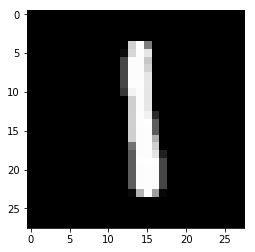

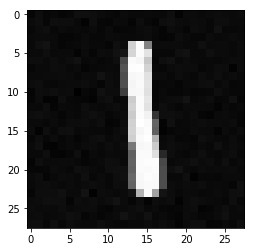

In [12]:
print("Augmenting data...")
_X = [X.copy()]
_y = [y.copy()]
for i in range(7):
    _X.append(X.copy() + np.random.normal(scale=3, size=X.shape))
    _y.append(y.copy())
X_aug = np.vstack(_X)
y_aug = np.hstack(_y)

plt.imshow(X[-1].reshape(28,28), cmap="gray")
plt.show()
plt.imshow(X_aug[-1].reshape(28,28), cmap="gray")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.33, random_state=43)

model = KNeighborsClassifier(n_neighbors=1)
print("fitting KNN (with augmentation)")
model.fit(X_train, y_train)
print("train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("test accuracy:", accuracy_score(y_test, model.predict(X_test)))

fitting KNN (with augmentation)
train accuracy: 1.0
test accuracy: 1.0


Hurra! Po dodaniu stosunkowo prostej augmentacji danych nasz model nauczył się perfekcyjnie generalizować na zbiór testowy! I nie musieliśmy tu stosować żadnej skomplikowanej sieci neuronowej, wystarczył KNN.

## Ćwiczenie 5 (4 pkt)

Wytłumaczyć, na czym polega błąd w powyższym rozumowaniu.

The mistake is that we use train_test_split on the augmented data, so the test set includes data from the training set only with a little noise, and the probability that there will be new, significantly different data in the test set is small. To avoid this, data augmentation should be used only for the training set.